In [1]:
# from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import datasets, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

pd.options.display.max_rows=60 #60
pd.options.display.max_columns=20 #20

In [2]:
# load data 

trainDF = pd.read_csv("~/Documents/kaggle/bnp/data/train.csv")
testDF = pd.read_csv("~/Documents/kaggle/bnp/data/test.csv")

In [4]:
# eliminate na value more than 120 columns
# trainDF = trainDF.dropna(thresh=120)
# testDF = testDF.dropna(thresh=120)

# just using small slice of data for faster computation
trainDF = trainDF[:1000]
testDF = testDF[:900]

In [5]:
testDF.head()

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,0,1.375465e+00,11.361141,C,4.200778,6.57700,2.081784,1.784386,0.011094,9.523810,...,7.619048,1.815241,1.112270e-07,AF,1.292368,3.903345,1.485925,0,2.333334,1.428572e+00
1,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,I,NaN,NaN,NaN,0,NaN,NaN
2,2,-4.903407e-07,8.201529,C,4.544371,6.55010,1.558442,2.467532,0.007164,7.142858,...,5.714286,1.970928,1.412265e-02,AV,1.128724,5.844156,1.475892,0,1.263157,-6.380022e-07
3,7,2.661870e+00,3.041241,C,1.657216,9.77308,2.078337,1.430855,1.252157,7.959596,...,4.404040,8.163614,1.100329e+00,B,1.988688,1.558753,2.448814,0,5.385474,1.493777e+00
4,10,1.252822e+00,11.283352,C,4.638388,8.52051,2.302484,3.510159,0.074263,7.612904,...,6.580644,1.325654,2.584588e-01,A,1.863796,2.666478,2.374275,0,0.681672,2.264151e+00


In [6]:
trainDF.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [7]:
# defining join, drop, imputation functions

def join(df, col):
    df = df.join(pd.get_dummies(df[col], prefix=col))
    df = df.drop(col, axis=1)
    return df

def drop(df, col):
    df = df.drop(col, axis=1)
    return df

# you may adjust this for better result, ex: mean or first quartile or third quartile
def fillna(df, col):
    df[col] = df[col].fillna(df[col].median(axis=0))
    return df

In [8]:
# v3, 24 30 31 47 52 66 71 74 75 79 91 107 110
# drop 22 38 56 62 113 125 129

# list_join = ['v3', 'v24', 'v30', 'v31', 'v47', 'v52', 'v66', 'v71', 'v74', 'v75', 'v79', 'v91', 'v107', 'v110']
# list_drop = ['ID', 'v22', 'v38', 'v56', 'v62', 'v113', 'v125', 'v112', 'v129']

# you may adjust this for better result
list_join = ['v3', 'v24', 'v30', 'v31', 'v47', 'v52', 'v66', 'v71', 'v74', 'v91']
list_drop = ['ID','v8', 'v22', 'v23', 'v25','v36','v37', 'v38', 'v46','v51','v53','v54', 'v56', 'v62','v63','v73','v75','v79','v81','v82','v89','v92','v95',
             'v105', 'v107','v108','v109','v110', 'v113', 'v112', 'v116','v117','v118','v119','v123','v124', 'v125', 'v128', 'v129']

trainDF = join(trainDF, list_join)
trainDF = drop(trainDF, list_drop)

testDF = join(testDF, list_join)
testDF = drop(testDF, list_drop)

# get columns index of null value
indexTrain = trainDF.isnull().any()
indexTest = testDF.isnull().any()

# get columns name index
columnsTrain = trainDF.columns
columnsTest = testDF.columns

# create null list
list_index_null_train = []
list_index_null_test = []
list_columns_null_train = []
list_columns_null_test = []

# append to null list index if nan
for i in range(len(indexTrain)):
    if indexTrain[i]: list_index_null_train.append(i)

for i in range(len(indexTest)):
    if indexTest[i]: list_index_null_test.append(i)

list_index_null_test = list(set(map(lambda x: x-1, list_index_null_train) + list_index_null_test))

# append columns name to list
list_columns_null_train = map(lambda x: (columnsTrain[x]), list_index_null_train)
list_columns_null_test = map(lambda x: (columnsTest[x]), list_index_null_test)

# imputation of null value
trainDF = fillna(trainDF, list_columns_null_train)
testDF = fillna(testDF, list_columns_null_test)

# re-shape test data columns
drop_columns = testDF.columns - trainDF.columns
testDF = drop(testDF, drop_columns)

# re-shape train data columns to same shape as test data
drop_columns = []
drop_columns = (trainDF.columns - testDF.columns).drop('target')
trainDF = drop(trainDF, drop_columns)

C:\Users\bramantyo.adrian\Anaconda2\lib\site-packages\ipykernel\__main__.py:49: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
C:\Users\bramantyo.adrian\Anaconda2\lib\site-packages\ipykernel\__main__.py:53: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


In [9]:
# validate null value

print testDF.isnull().values.any()
print trainDF.isnull().values.any()

print list_index_null_test
print list_index_null_train

False
False
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
[1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83]


In [10]:
# normalize using standard scaler

y_train = trainDF.iloc[:, 0].values
x_train = trainDF.ix[:, 'v1':]
x_test = testDF.ix[:, 'v1':]

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)


In [11]:
# feature correlation / importance

forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
forest.fit(x_train, y_train)
importances = forest.feature_importances_
print(importances)

# sort by importance
indices = np.argsort(importances)[::-1]
print indices

# features sort by importances

[  6.96020777e-03   6.60620344e-03   6.00397549e-03   7.45167155e-03
   6.36904989e-03   5.65227692e-03   5.19404714e-03   3.91019012e-02
   8.43878928e-03   4.24762112e-02   6.30634445e-03   3.93469938e-02
   5.99585669e-03   6.50773419e-03   4.98546471e-03   5.38327052e-03
   5.39861386e-03   5.67606417e-03   3.69006202e-02   5.43898768e-03
   6.54930039e-03   5.51397547e-03   5.18019764e-03   5.50650617e-03
   4.82886251e-03   3.76462746e-02   5.73227592e-03   5.99764360e-03
   3.47572751e-02   5.61047472e-03   6.23781613e-03   5.83888901e-03
   5.55120309e-03   6.07951311e-03   5.65872970e-03   5.36031357e-03
   8.60524049e-02   5.21963604e-03   6.19517765e-03   6.49964841e-03
   6.68173751e-03   6.77938707e-03   5.71746649e-03   5.22004497e-03
   5.08319174e-03   5.37682016e-03   6.60751195e-03   5.76812121e-03
   7.33937844e-03   7.85699772e-03   5.03788810e-03   6.31318256e-03
   5.89792276e-03   5.90041811e-03   5.02935163e-03   4.78229089e-03
   6.48625428e-03   4.97462208e-03

In [29]:
# print all features that have correlation more than 0.01
# you may adjust this parameter for better result

labels = trainDF.columns
map(lambda x: "`%2d. %-*s %f" % (x + 1, 30, labels[indices[x]], importances[indices[x]]), range(x_train.shape[1]))

# for f in range(x_train.shape[1]):
#     print("%2d. %-*s %f" % (f + 1, 30, labels[indices[f]], importances[indices[f]]))

['` 1. v49                            0.086052',
 '` 2. v11                            0.042476',
 '` 3. v13                            0.039347',
 '` 4. v9                             0.039102',
 '` 5. v111                           0.038907',
 '` 6. v33                            0.037646',
 '` 7. v20                            0.036901',
 '` 8. v39                            0.034757',
 '` 9. v31_C                          0.014921',
 '`10. v47_G                          0.014857']

In [13]:
# you may adjust this parameter
x_train = forest.transform(x_train, threshold=.01)
x_test = forest.transform(x_test, threshold=.01)

C:\Users\bramantyo.adrian\Anaconda2\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\bramantyo.adrian\Anaconda2\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


[ 89 179 269 359 449 539 629 719 809 899]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


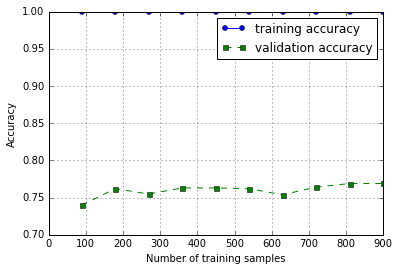

In [20]:
# you can change model and run another analysis on another cell
# ex using another kernel or bagging, boster, etc
svm = SVC(kernel='rbf', C=100.0, gamma=0.1, random_state=0)
lgr = LogisticRegression(C=1.0)
rfc = RandomForestClassifier(n_estimators=1000)

train_sizes, train_scores, test_scores = learning_curve(estimator=rfc, X=x_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

print train_sizes
print train_mean

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
# plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
# plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.ylim([0.7, 1])
plt.show()

[ 89 179 269 359 449 539 629 719 809 899]
[ 0.96966292  0.95251397  0.92156134  0.90445682  0.88507795  0.8716141
  0.85945946  0.85493741  0.85142151  0.8458287 ]


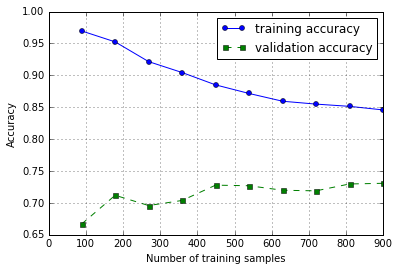

In [21]:
# same as above but using svm
train_sizes, train_scores, test_scores = learning_curve(estimator=svm, X=x_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

print train_sizes
print train_mean

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
# plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
# plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.ylim([0.65, 1])
plt.show()

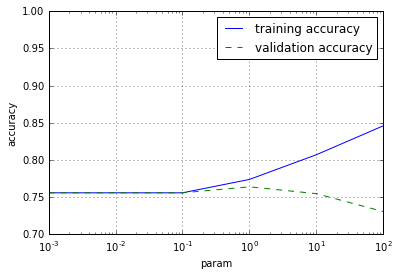

In [16]:
# analyze parameter on svm 

param_range = [.001, .01, .1, 1., 10., 100.]
train_scores, test_scores = validation_curve(estimator=svm, X=x_train, y=y_train, param_name='C', param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std= np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', label='training accuracy')
plt.plot(param_range, test_mean, color='green', linestyle='--', label='validation accuracy')
plt.xscale('log')
plt.grid()
plt.xlabel('param')
plt.ylabel('accuracy')
plt.legend(loc='upper right')
plt.ylim([0.7, 1])
plt.show()

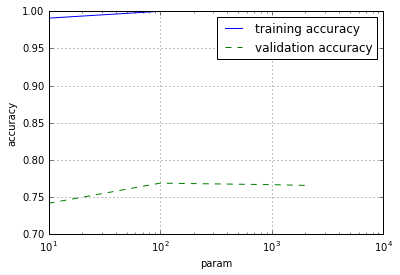

In [30]:
# analyze parameter on random forest
estimator_range = [10, 100, 1000, 2000]
train_scores, test_scores = validation_curve(estimator=rfc, X=x_train, y=y_train, param_name='n_estimators', param_range=estimator_range, cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std= np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(estimator_range, train_mean, color='blue', label='training accuracy')
plt.plot(estimator_range, test_mean, color='green', linestyle='--', label='validation accuracy')
plt.xscale('log')
plt.grid()
plt.xlabel('param')
plt.ylabel('accuracy')
plt.legend(loc='upper right')
plt.ylim([0.7, 1])
plt.show()

In [17]:
# create list contain parameter of svm and randomforest
param_grid = [{'C': param_range,
              'kernel': ['linear']},
             {'C': param_range,
             'gamma': param_range,
             'kernel': ['rbf']}]
param_grid_estimator = [{'n_estimators': estimator_range}]


In [18]:
# search the best parameter for svm
gs = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.764
{'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1}


In [19]:
# search the best parameter for randomforest
gs = GridSearchCV(estimator=rfc, param_grid=param_grid_estimator, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.769
{'n_estimators': 1000}
